In [1]:
#Lets import basic standard libraries first 
#!pip install plotly
import pandas as pd #Pandas library
import numpy as np  #Numpy library
import seaborn as sns #Seaborn libaray for visualisation
import pickle
import matplotlib.pyplot as plt #Matpltolib Pyplot libaray for visualisation
plt.figure(figsize=(16,6))
%matplotlib inline


from sklearn.model_selection import train_test_split , GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix,accuracy_score



import warnings # Warnings library to ignore warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
mapping_Reason_Code= pd.read_excel('./Data Elements_Value Mapping.xlsx',sheet_name="Reason code & Condition Code")
mapping_Others_Code= pd.read_excel('./Data Elements_Value Mapping.xlsx',sheet_name="Others")
mapping_ISO_Country_Code= pd.read_excel('./Data Elements_Value Mapping.xlsx',sheet_name="ISO_Country & Currency Codes")

visaData=pd.read_excel("./Chargeback Updated Final Data Set_V8.xlsm",sheet_name="VISA")

In [3]:
visaData.shape

(2291, 73)

In [4]:
visaData.head(2)

,Chargeback Request Id,Card Number,Posted Amount (USD),Authorization Amount (USD),Txn Date,Central Processing Date,Authorization Date,Txn_Type,Unique Identifier,Issuer Country,...,Txn Merchant Country in Europe Flg?,Txn Merchant Country in AP Flg?,Txn Merchant Country in CANADA Flg?,Txn Merchant Country in CMEA Flg?,Txn Authorized through Emergency services,Txn POS Env value = R?,Auth Code Blank on Txn,CRC,Reason_Code,Doc_Ind
0,101,4AAABBBBCCCC0101,44.32,44.32,2017-01-04 00:00:00,2017-01-04 00:00:00,2017-01-04 00:00:00,Purchase,VPUR101,US,...,N,Y,N,N,N,N,Y,Space,RC 83 C1,Y
1,102,4AAABBBBCCCC0102,57.85,57.85,2017-02-04 00:00:00,2017-02-04 00:00:00,2017-02-04 00:00:00,Purchase,VPUR102,US,...,Y,N,N,N,N,N,Y,Space,RC 83 C1,Y


In [5]:
visaData.describe()

,Chargeback Request Id,Posted Amount (USD),Authorization Amount (USD),Merchant Category Code,Merchant Category Code on Auth,Service Code,Chargeback_Amount (USD)
count,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000,2291.000000
mean,1246.000000,68.258104,67.697254,3950.059363,3950.103012,198.730249,68.191785
std,661.499055,236.743901,236.792334,1571.331384,1571.317771,14.896987,236.745090
min,101.000000,0.300000,0.300000,1711.000000,1711.000000,101.000000,0.300000
25%,673.500000,29.910000,27.850000,3022.000000,3022.000000,201.000000,29.910000
50%,1246.000000,53.430000,52.390000,3041.000000,3041.000000,201.000000,53.170000
75%,1818.500000,80.800000,80.600000,4215.000000,4215.000000,201.000000,80.800000
max,2391.000000,7715.760000,7715.760000,8641.000000,8642.000000,201.000000,7715.760000


In [6]:
##If we explore dataset ,we find that only two rows having very high values of 7715.76 which will add difficluty to 
## explore the dataset in visualisation so lets drop only 2 records and take other records

In [7]:
maxvalue=visaData["Posted Amount (USD)"].max()
maxvalue


7715.76

In [8]:
visaData=visaData[visaData["Posted Amount (USD)"]!=maxvalue]

In [9]:
visaData.shape

(2289, 73)

## Data Cleaning

In [10]:
# If we explore dataset we will find that multiple columns are having missing, blank , null values which we need to clean
visaData["POS Entry Mode"].unique()



array(['00', '01', 'Space', '06', '02', '90', 90, '05', '95', '07', '91',
       91], dtype=object)

In [11]:
#Let's drop columns which seems wont contribute to analysis and are unique values only for every transaction
visaData.drop(columns=["Chargeback Request Id","Card Number","Merchant Name"],axis=1,inplace=True)
visaData.drop(columns=["Txn Date","Central Processing Date","Authorization Date"],axis=1,inplace=True)
visaData.drop(columns=["Unique Identifier","Authorization code"],axis=1,inplace=True)
visaData.drop(columns=["Doc_Ind"],axis=1,inplace=True)


In [12]:
# Next ,lets clean missing, Blank , Space values in categorical area as a 
for column in visaData.columns:    
    if(visaData[column].dtypes=="object"):       
        if(column!="Terminal Indicator"):
            visaData[column]=visaData[column].replace({"Space":"99","Blank":"99","N/A":"99",np.NAN:"99"})
        else:
            visaData[column]=visaData[column].replace({"Space":99,"Blank":99,"N/A":"99",np.NAN:99})
    else:
        visaData[column].fillna(method='ffill')    

In [13]:
# If we explore below dataset , we dont have any null, missing , space , blank values 
visaData.head()

,Posted Amount (USD),Authorization Amount (USD),Txn_Type,Issuer Country,Merchant Country,Merchant Category Code,Merchant Category Code on Auth,Network,POS Entry Mode,POS Entry Mode on Auth,...,Txn Merchant Country in US Flg?,Txn Merchant Country in Europe Flg?,Txn Merchant Country in AP Flg?,Txn Merchant Country in CANADA Flg?,Txn Merchant Country in CMEA Flg?,Txn Authorized through Emergency services,Txn POS Env value = R?,Auth Code Blank on Txn,CRC,Reason_Code
0,44.32,44.32,Purchase,US,IN,3000,3000,VSN,00,00,...,N,N,Y,N,N,N,N,Y,99,RC 83 C1
1,57.85,57.85,Purchase,US,FR,3001,3001,VSN,00,00,...,N,Y,N,N,N,N,N,Y,99,RC 83 C1
2,83.77,83.77,Purchase,US,FR,3002,3002,BII,01,01,...,N,Y,N,N,N,N,N,Y,99,RC 83 C1
3,56.44,56.44,Purchase,US,IN,3011,3011,BII,99,99,...,N,N,Y,N,N,N,N,Y,99,RC 83 C1
4,10.21,10.21,Purchase,US,IN,5533,5533,VSN,01,01,...,N,N,Y,N,N,N,N,Y,99,RC 83 C1


In [14]:
#visaData.isnull().sum() 

## Visualisation

Text(0.5, 1.0, 'My title')

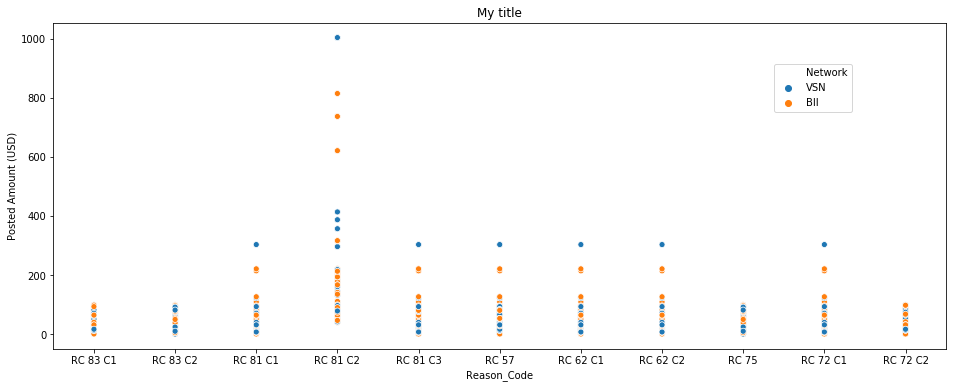

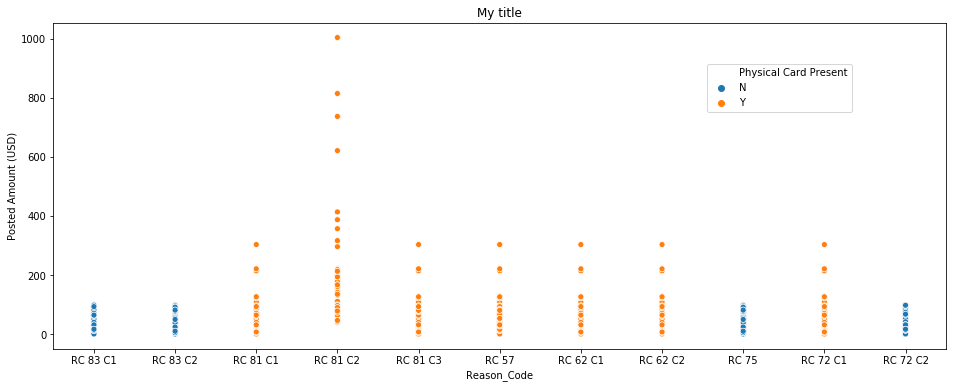

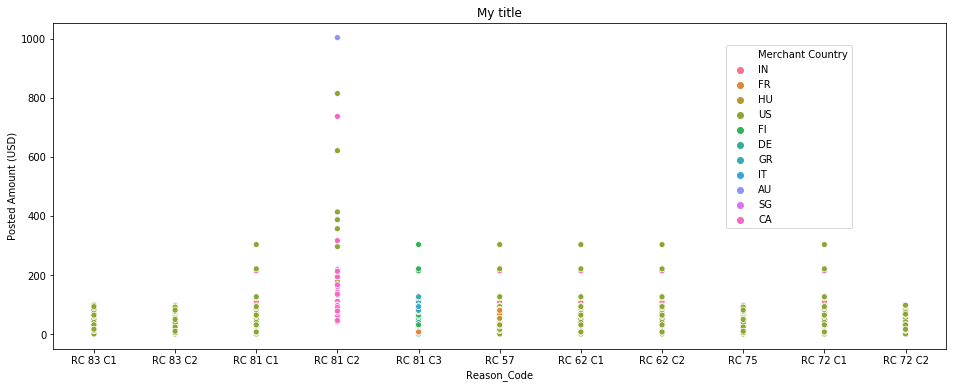

In [15]:
plt.figure(figsize=(16, 6))

cmap = sns.cubehelix_palette(rot=2, as_cmap=True)
ax = sns.scatterplot(y="Posted Amount (USD)", x="Reason_Code",
                     hue="Network",
                     sizes=(320, 200),
                     data=visaData)
ax.legend(loc='center right', bbox_to_anchor=(0.9, 0.8), ncol=1)
plt.title('My title')


plt.figure(figsize=(16, 6))

cmap = sns.cubehelix_palette(rot=2, as_cmap=True)
ax = sns.scatterplot(y="Posted Amount (USD)", x="Reason_Code",
                     hue="Physical Card Present",
                     sizes=(320, 200),
                     data=visaData)
ax.legend(loc='center right', bbox_to_anchor=(0.9, 0.8), ncol=1)
plt.title('My title')


plt.figure(figsize=(16, 6))

cmap = sns.cubehelix_palette(rot=2, as_cmap=True)
ax = sns.scatterplot(y="Posted Amount (USD)", x="Reason_Code",
                     hue="Merchant Country",
                     sizes=(320, 200),
                     data=visaData)
ax.legend(loc='center right', bbox_to_anchor=(0.9, 0.65), ncol=1)
plt.title('My title')

In [16]:
def plot_graph(X,Dataframe,Title):
    fig = plt.figure(figsize=(15,5))
    ax = sns.countplot(x=X, data=Dataframe ,palette='pastel' ,edgecolor=sns.color_palette("dark", 3))
    ax.set_title(Title)
    ax.legend(loc='upper right')

    for t in ax.patches:
        if (np.isnan(float(t.get_height()))):
            ax.annotate(0, (t.get_x(), 0))
        else:
            ax.annotate(str(format(int(t.get_height()), ',d')), (t.get_x(), t.get_height()*1.01))
    plt.show();   
    

No handles with labels found to put in legend.


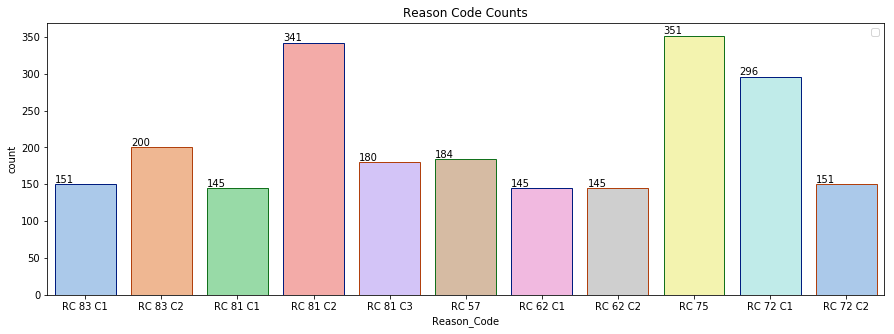

No handles with labels found to put in legend.


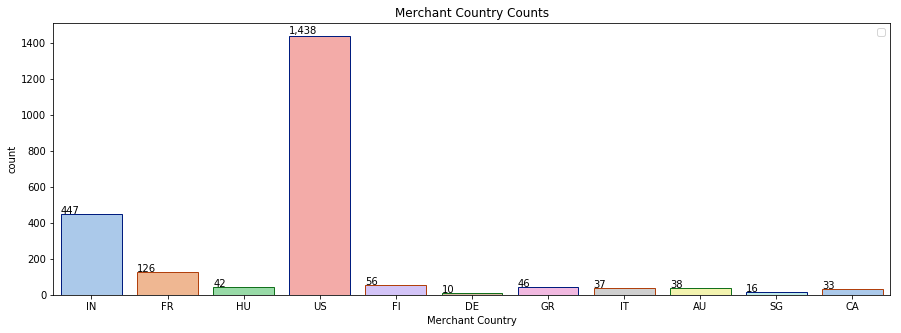

In [17]:
plot_graph("Reason_Code",visaData,"Reason Code Counts")

plot_graph("Merchant Country",visaData,"Merchant Country Counts")



No handles with labels found to put in legend.


Text(0.5, 1.0, 'Posted Amount vs Merchant County')

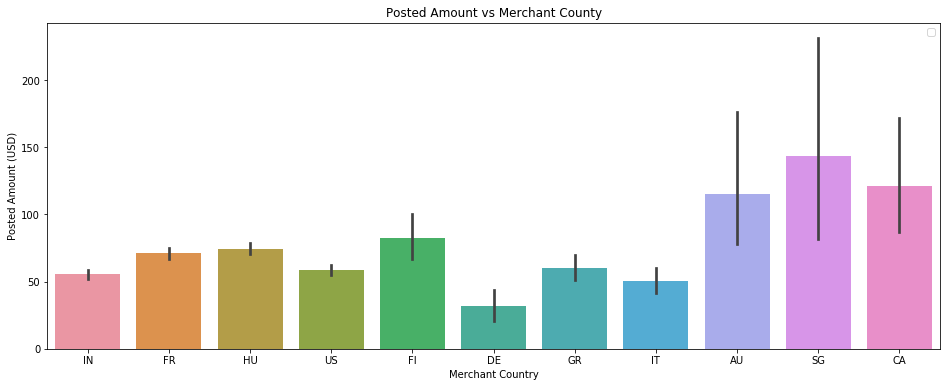

In [18]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(y="Posted Amount (USD)", x="Merchant Country",data=visaData)
ax.legend(loc="upper right")
plt.title('Posted Amount vs Merchant County')

<Figure size 1872x1872 with 0 Axes>

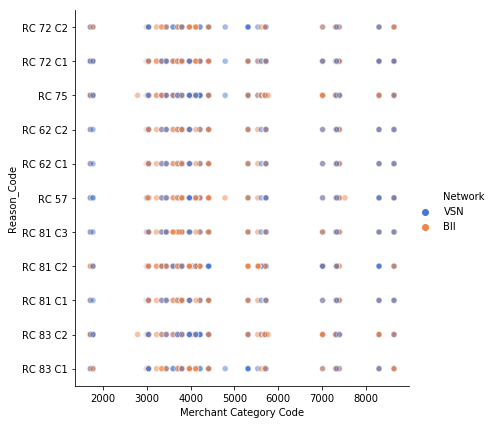

In [19]:
plt.figure(figsize=(26, 26))
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Merchant Category Code", y="Reason_Code", hue='Network',
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=visaData)

<Figure size 1872x1872 with 0 Axes>

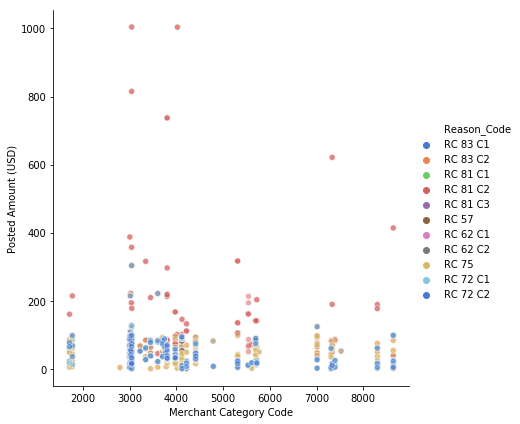

In [20]:
plt.figure(figsize=(26, 26))
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Merchant Category Code", y="Posted Amount (USD)", hue='Reason_Code',
            sizes=(40, 40), alpha=.5, palette="muted",
            height=6, data=visaData)

<Figure size 1872x1872 with 0 Axes>

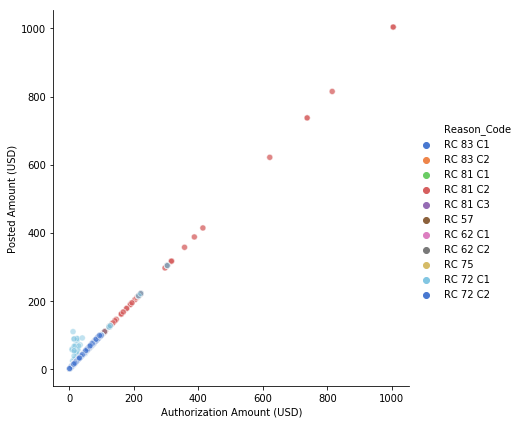

In [21]:
plt.figure(figsize=(26, 26))
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Authorization Amount (USD)", y="Posted Amount (USD)", hue='Reason_Code',
            sizes=(40, 40), alpha=.5, palette="muted",
            height=6, data=visaData)

<Figure size 1872x1872 with 0 Axes>

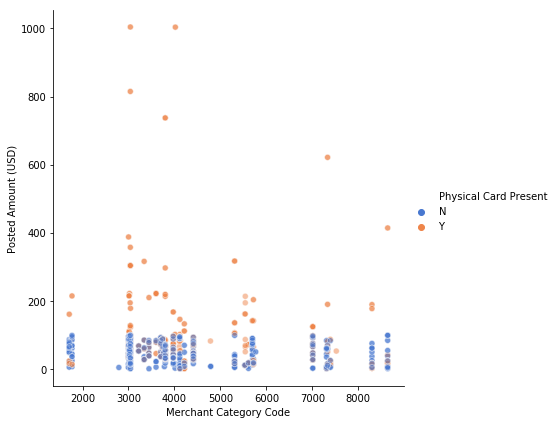

In [22]:
plt.figure(figsize=(26, 26))
# Plot miles per gallon against horsepower with other semantics
sns.relplot(x="Merchant Category Code", y="Posted Amount (USD)", hue='Physical Card Present',
            sizes=(40, 40), alpha=.5, palette="muted",
            height=6, data=visaData)

In [23]:
visaData["Terminal Indicator"].unique()

array([3, 1, 99], dtype=object)

In [24]:
visaData.head(2)

,Posted Amount (USD),Authorization Amount (USD),Txn_Type,Issuer Country,Merchant Country,Merchant Category Code,Merchant Category Code on Auth,Network,POS Entry Mode,POS Entry Mode on Auth,...,Txn Merchant Country in US Flg?,Txn Merchant Country in Europe Flg?,Txn Merchant Country in AP Flg?,Txn Merchant Country in CANADA Flg?,Txn Merchant Country in CMEA Flg?,Txn Authorized through Emergency services,Txn POS Env value = R?,Auth Code Blank on Txn,CRC,Reason_Code
0,44.32,44.32,Purchase,US,IN,3000,3000,VSN,00,00,...,N,N,Y,N,N,N,N,Y,99,RC 83 C1
1,57.85,57.85,Purchase,US,FR,3001,3001,VSN,00,00,...,N,Y,N,N,N,N,N,Y,99,RC 83 C1


## Data Mapping from Mapping Sheets

In [25]:

area_dict = dict(zip(mapping_ISO_Country_Code["ISO 3166-1 2 Letter Code"],mapping_ISO_Country_Code["ISO 3166-1 Number"]))


#Ref - https://pbpython.com/categorical-encoding.html

cleanup_nums = {"Txn_Type":     {
                                    "Purchase": 1, 
                                    "Cash Withdrawal": 2,
                                    "Merchandise Return": 3,
                                    "Merchandise Return": 3,
                                    "Money Transfer": 4,
                                    "Payment": 5,
                                    "Quasi Cash": 6,
                                    "Funds Disbursement": 7                                
                                },
                
                "Network":      {
                                    "VSN": 1 ,
                                    "BII": 2 ,
                                    "MC": 3 ,
                                    "MMS": 4 ,
                                    "ILK": 5 ,
                                    "VSV": 6 ,
                                    "VSP": 7                     
                                },
                
                "POS Entry Mode":{
                                    "Space":99,
                                    "01":1,
                                    "02":2,
                                    "03":3,                      
                                    "04":4,
                                    "05":5,
                                    "06":6,
                                    "07":7,
                                    "84":84,
                                    "90":90,
                                    "91":91,
                                    "95":95,
                                    "96":96                    
                                 },

                "POS Entry Mode on Auth":{
                                    "Space":99,
                                    "01":1,
                                    "02":2,
                                    "03":3,                      
                                    "04":4,
                                    "05":5,
                                    "06":6,
                                    "07":7,
                                    "84":84,
                                    "90":90,
                                    "91":91,
                                    "95":95,
                                    "96":96                    
                                 },
                
                "POS Environment":{
                                    "Space":99,
                                    "C":1,
                                    "R":2,
                                    "I":3                    
                                },
                #Service Code keys entry not done 
                
                "MOTO_ECI_Ind":{
                                    "Space":99,
                                    "1":1,
                                    "2":2,
                                    "3":3,                      
                                    "4":4,
                                    "5":5,
                                    "6":6,
                                    "7":7,
                                    "8":8                                    
                                 },
                "Terminal Indicator":{
                                    "Space":99,
                                    "1":1,
                                    "2":2,
                                    "3":3,                      
                                    "4":4,
                                    "5":5,
                                    "9":9                                    
                                 },
                
                "Terminal capability code":{
                                    "Space":99,
                                    "0":0,
                                    "1":1,
                                    "2":2,
                                    "3":3,                      
                                    "4":4,
                                    "5":5,
                                    "6":6,
                                    "7":7,
                                    "8":8,
                                    "9":9                                    
                                 },
                
                "Cardholder ID Method":{
                                    "Space":99,                                    
                                    "1":1,
                                    "2":2,
                                    "3":3,                      
                                    "4":4                                           
                                 },
                
                "UCAF":          {
                                    "Blank":99,
                                    "0":0,                                    
                                    "1":1,
                                    "2":2,
                                    "3":3,                      
                                    "4":2,
                                    "5":3,                      
                                    "6":2,
                                    "7":3
                                 },
                
                "Floor Limit":{
                                    "Space":99,
                                    "A":0,
                                    "B":1,
                                    "C":2,
                                    "D":3,                      
                                    "E":4,
                                    "I":5,
                                    "Z":6                                    
                                 },
                
                "CVV2 Result":{
                                    "Space":99,
                                    "M":0,
                                    "N":1,
                                    "P":2,
                                    "S":3,                      
                                    "U":4                                    
                                 },
                "Pin Present ?":{
                                    "N":0,
                                    "Y":1
                                    
                                 },
                
                 "CB Rights Ind":{
                                    "Blank":99,
                                    "01":1,
                                    "02":2,
                                    "03":3,                      
                                    "04":4,
                                    "05":5,
                                    "08":8,
                                    "09":9,
                                    "10":10,
                                    "11":11,
                                    "12":12,
                                    "13":13,
                                    "14":14,
                                    "17":17
                                 },
                
                
                "Issuer Country": area_dict,
                "Merchant Country": area_dict
                
                }


mappedData=visaData.replace(cleanup_nums)


In [26]:
#mappedData["Physical Card Present"] = mappedData["Physical Card Present"].apply(lambda x: 0 if x == "N" else 1)
columnnames=[
                "Physical Card Present",
                "Fraud Dispute",
                "Authorization Denied by Customer",
                "Report fictitious/invalid Card No",
                "Counterfiet Card Ind",
                "Card listed in Exception File Ind",
                "Cardholder Participation",
                "Legible Imprint with Merchant",
                "Valid Cardholder Signature with Merchant",
                "Card in posession with Cardholder at time of Fraud",
                "Cardholder Does NOT Recognize ",
                "EMPS Ind",
                "Stand-In Auth Ind",
                "Incorrect Track Data on Auth",
                "Incorrect Txn Data on Auth",
                "Partial Or Non-Match Auth Ind",
                "EMV Liability Shift Ind",
                "PIN Preferring Chip Card",
                "EMV-PIN compliant Terminal",
                "Prev_Txn_Flag",
                "Shipping Cost Included?",
                "Emergency Cash Disbursement",
                "Secure E-Comm Txn?",
                "CVV2 Code Result - N or U?",
                "Report of Invalid/illegible/absent CVV2 by customer",
                "Issuer in US  Flg ?",             
                "Issuer in Europe  Flg ?",
                "Issuer in CANADA Flg ?",
                "Issuer in AP  Flg ?",
                "Issuer in CMEA  Flg ?",
                "Txn Merchant Country in US Flg?",
                "Txn Merchant Country in Europe Flg?",
                "Txn Merchant Country in AP Flg?",
                "Txn Merchant Country in CANADA Flg?",
                "Txn Merchant Country in CMEA Flg?",
                "Txn Authorized through Emergency services",
                "Txn POS Env value = R?",
                "Auth Code Blank on Txn"
    
            ]

for cols in columnnames:
    mappedData[cols] = mappedData[cols].apply(lambda x: 0 if x == "N" else (0 if x == "N/A" else 1 ))#Marvah



In [27]:
mappedData.drop(columns="Reason_Code",axis=1, inplace=True)
mappedData.head(2)

,Posted Amount (USD),Authorization Amount (USD),Txn_Type,Issuer Country,Merchant Country,Merchant Category Code,Merchant Category Code on Auth,Network,POS Entry Mode,POS Entry Mode on Auth,...,Issuer in CMEA Flg ?,Txn Merchant Country in US Flg?,Txn Merchant Country in Europe Flg?,Txn Merchant Country in AP Flg?,Txn Merchant Country in CANADA Flg?,Txn Merchant Country in CMEA Flg?,Txn Authorized through Emergency services,Txn POS Env value = R?,Auth Code Blank on Txn,CRC
0,44.32,44.32,1,840,356,3000,3000,1,0,0,...,0,0,0,1,0,0,0,0,1,99
1,57.85,57.85,1,840,250,3001,3001,1,0,0,...,0,0,1,0,0,0,0,0,1,99


In [28]:
mappedData.to_csv("./mappedData.csv")

## Hot Encoded Data (Dummies)

In [29]:
predict = visaData["Reason_Code"]
inputdata= visaData.drop(columns="Reason_Code",axis=1)

In [30]:
encodedData=pd.get_dummies(inputdata)
encodedData.head()

,Posted Amount (USD),Authorization Amount (USD),Merchant Category Code,Merchant Category Code on Auth,Service Code,Chargeback_Amount (USD),Txn_Type_Purchase,Issuer Country_US,Merchant Country_AU,Merchant Country_CA,...,Txn Merchant Country in CMEA Flg?_N,Txn Merchant Country in CMEA Flg?_Y,Txn Authorized through Emergency services_N,Txn Authorized through Emergency services_Y,Txn POS Env value = R?_N,Auth Code Blank on Txn_N,Auth Code Blank on Txn_Y,CRC_28,CRC_30,CRC_99
0,44.32,44.32,3000,3000,201,44.32,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1
1,57.85,57.85,3001,3001,201,57.85,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1
2,83.77,83.77,3002,3002,201,83.77,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1
3,56.44,56.44,3011,3011,201,56.44,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1
4,10.21,10.21,5533,5533,201,10.21,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1


In [31]:
encodedData.to_csv("./encodedData.csv")

# Feature Engineering

In [32]:
encodedData.head(2)

,Posted Amount (USD),Authorization Amount (USD),Merchant Category Code,Merchant Category Code on Auth,Service Code,Chargeback_Amount (USD),Txn_Type_Purchase,Issuer Country_US,Merchant Country_AU,Merchant Country_CA,...,Txn Merchant Country in CMEA Flg?_N,Txn Merchant Country in CMEA Flg?_Y,Txn Authorized through Emergency services_N,Txn Authorized through Emergency services_Y,Txn POS Env value = R?_N,Auth Code Blank on Txn_N,Auth Code Blank on Txn_Y,CRC_28,CRC_30,CRC_99
0,44.32,44.32,3000,3000,201,44.32,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1
1,57.85,57.85,3001,3001,201,57.85,1,1,0,0,...,1,0,1,0,1,0,1,0,0,1


# Data Split

In [33]:
x=encodedData.values
y=visaData["Reason_Code"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1602, 163)
(1602,)
(687, 163)
(687,)


# Decision Tree ( Encoded Data)

In [34]:
dt=DecisionTreeClassifier(criterion="entropy")
dt_model=dt.fit(x_train,y_train)


In [35]:
dt_model.feature_importances_
list(zip(encodedData.columns,dt_model.feature_importances_))

[('Posted Amount (USD)', 0.0),
 ('Authorization Amount (USD)', 0.0),
 ('Merchant Category Code', 0.0),
 ('Merchant Category Code on Auth', 0.0013561551823560417),
 ('Service Code', 0.0),
 ('Chargeback_Amount (USD)', 0.0),
 ('Txn_Type_Purchase', 0.0),
 ('Issuer Country_US', 0.0),
 ('Merchant Country_AU', 0.0),
 ('Merchant Country_CA', 0.0),
 ('Merchant Country_DE', 0.0),
 ('Merchant Country_FI', 0.0),
 ('Merchant Country_FR', 0.0),
 ('Merchant Country_GR', 0.0),
 ('Merchant Country_HU', 0.0),
 ('Merchant Country_IN', 0.0),
 ('Merchant Country_IT', 0.0),
 ('Merchant Country_SG', 0.0),
 ('Merchant Country_US', 0.0),
 ('Network_BII', 0.0),
 ('Network_VSN', 0.0),
 ('POS Entry Mode_90', 0.0),
 ('POS Entry Mode_91', 0.0),
 ('POS Entry Mode_00', 0.0),
 ('POS Entry Mode_01', 0.0),
 ('POS Entry Mode_02', 0.0),
 ('POS Entry Mode_05', 0.0),
 ('POS Entry Mode_06', 0.0),
 ('POS Entry Mode_07', 0.0),
 ('POS Entry Mode_90', 0.0),
 ('POS Entry Mode_91', 0.0),
 ('POS Entry Mode_95', 0.0),
 ('POS Entry M

In [36]:
from sklearn import tree
with open("CardTree.dot", 'w') as f:
    f = tree.export_graphviz(dt_model, out_file=f, feature_names=encodedData.columns)

In [37]:
dt_prd=dt_model.predict(x_test)
print(accuracy_score(y_test,dt_prd))
df_confusion = confusion_matrix(y_test,dt_prd)
df_confusion

0.9941775836972343


array([[ 61,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  47,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  45,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  98,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  37,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  94,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,  52,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 100,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  57,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  38,   2],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   2,  54]],
      dtype=int64)

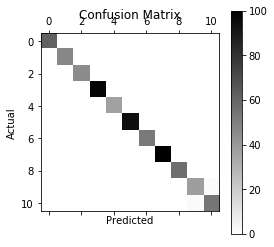

In [38]:
def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(df_confusion)

In [39]:
print(metrics.classification_report(y_test,dt_prd))

              precision    recall  f1-score   support

       RC 57       1.00      1.00      1.00        61
    RC 62 C1       1.00      1.00      1.00        47
    RC 62 C2       1.00      1.00      1.00        45
    RC 72 C1       1.00      1.00      1.00        98
    RC 72 C2       1.00      1.00      1.00        37
       RC 75       1.00      1.00      1.00        94
    RC 81 C1       1.00      1.00      1.00        52
    RC 81 C2       1.00      1.00      1.00       100
    RC 81 C3       1.00      1.00      1.00        57
    RC 83 C1       0.95      0.95      0.95        40
    RC 83 C2       0.96      0.96      0.96        56

   micro avg       0.99      0.99      0.99       687
   macro avg       0.99      0.99      0.99       687
weighted avg       0.99      0.99      0.99       687



# Model saving using Pickle library

In [40]:
import pickle
#https://medium.com/analytics-vidhya/how-to-deploy-simple-machine-learning-models-for-free-56cdccc62b8d
# Saving model to disk
# Serialize dt_model object into a file called mlp_nn.pkg on disk using pickle
with open('dt_model.pkl', 'wb') as handle:
    pickle.dump(dt_model, handle, pickle.HIGHEST_PROTOCOL)

In [41]:
with open('dt_model.pkl', 'rb') as handle:
    dt_model = pickle.load(handle)    
# no we can call various methods over mlp_nn as as:
# Let X_test be the feature (UNIX timestamp) for which we want to predict the output 
result = dt_model.predict(x_test)

# Test Pickle Model 

In [42]:
testvalues=encodedData.loc[encodedData['Posted Amount (USD)'] ==24.36].values

In [43]:
dt_model.predict(testvalues)


array(['RC 72 C2'], dtype=object)

# Test model is working till here

In [44]:
STOP HERE

SyntaxError: invalid syntax (<ipython-input-44-a6774c8535dd>, line 1)

# Grid Search
Grid-searching is the process of scanning the data to configure optimal parameters for a given model.

In [ ]:
# Different parameters we want to test

max_depth = [5,10,15] 
criterion = ['gini', 'entropy']

In [ ]:
# Building the model

my_tree_three = tree.DecisionTreeClassifier()

grid = GridSearchCV(estimator = my_tree_three, cv=3, 
                    param_grid = dict(max_depth = max_depth, criterion = criterion))

In [ ]:
grid.fit(x,y)

In [ ]:
grid.score(x,y)

In [ ]:
ax = sns.heatmap(encodedData, cmap="YlGnBu")

# VARUN TEST with Mapped Data

In [ ]:
x=mappedData.values
y=visaData["Reason_Code"]

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

In [ ]:
dt=DecisionTreeClassifier(criterion="entropy")
dt_model=dt.fit(x_train,y_train)

from sklearn import tree
with open("CardTree.dot", 'w') as f:
    f = tree.export_graphviz(dt_model, out_file=f, feature_names=mappedData.columns)
    
    
dt_prd=dt_model.predict(x_test)
print(accuracy_score(y_test,dt_prd))
df_confusion = confusion_matrix(y_test,dt_prd)
df_confusion


def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

plot_confusion_matrix(df_confusion)

print(metrics.classification_report(y_test,dt_prd))

In [ ]:
mappedData.head()

In [ ]:
STOP HERE 

# Random Forest

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.30,random_state=1)

In [ ]:
rf_clf=RandomForestClassifier(max_depth = 10, min_samples_split=2, n_estimators = 10, random_state = 123)
rf_model=rf_clf.fit(x_train,y_train)
rf_prediction=rf_model.predict(x_test)

In [ ]:
print(accuracy_score(y_test,rf_prediction))

### Random Search

Using Randomized Grid Search, we can define a grid of hyperparameters and randomly sample from the grid to get the best combination of values.

In [ ]:
'''
# Different parameters we want to test

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
'''

In [ ]:
'''

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
'''

In [ ]:
# Importing RandomizedSearchCV
'''
from sklearn.model_selection import RandomizedSearchCV
'''

In [ ]:

'''
forest_two = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = forest_two, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42)
                               
'''

In [ ]:
#rf_random.fit(x,y)

In [ ]:
#rf_random.best_params_
#rf_random.best_score_

In [ ]:
'''
y=visaData["Reason_Code"]
visaData.drop(columns="Reason_Code", axis=1)
#columns = ["Petal.Width", "Sepal.Length","Petal.Length"]
features=visaData.values
x=features
x
'''